In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from torchvision import datasets
from torchvision.transforms import ToTensor

(a)

Data loading and preprocessing:

In [2]:
# Download MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
# Convert to a numpy array and flatten
x_train_flat = np.array([img.numpy().reshape(-1) for img, label in mnist_train], dtype=np.float64)
y_train = np.array([label for img, label in mnist_train])
# Select the first 1000 images in each class
x_train_flat = np.vstack([x_train_flat[y_train == i][:1000] for i in range(10)])
y_train = np.hstack([y_train[y_train == i][:1000] for i in range(10)])

x_train_flat.shape, y_train.shape

((10000, 784), (10000,))

Visualize the average digit-1 template:

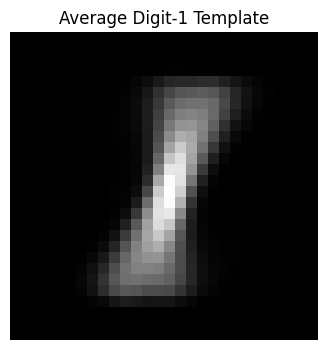

In [3]:
digit1_images = x_train_flat[y_train == 1]
digit1_mean = np.mean(digit1_images, axis=0)

plt.figure(figsize=(4, 4))
plt.imshow(digit1_mean.reshape(28, 28), cmap='gray')
plt.title("Average Digit-1 Template")
plt.axis('off')
plt.show()

Calculate PCA using two methods: 

The Gram matrix technique and the standard covariance approach.

In [4]:
# The Gram matrix: G = XX^T
def pca_gram(X, n_components):
    start_time = time.time()
    mean_X = np.mean(X, axis=0)
    X = X - mean_X
    G = X @ X.T
    eigvals, eigvecs = np.linalg.eigh(G)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx][:n_components]
    eigvecs = eigvecs[:, idx][:, :n_components]
    eigvecs = X.T @ eigvecs
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
    end_time = time.time()
    return eigvecs, eigvals, mean_X, end_time - start_time

In [5]:
# Standard covariance approach: C = (1/n)X^TX
def pca_std(X, n_components):
    start_time = time.time()
    mean_X = np.mean(X, axis=0)
    X = X - mean_X
    C = (X.T @ X) / X.shape[0]
    eigvals, eigvecs = np.linalg.eigh(C)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx][:n_components]
    eigvecs = eigvecs[:, idx][:, :n_components]
    end_time = time.time()
    return eigvecs, eigvals, mean_X, end_time - start_time

Record computational time:

In [6]:
n_components = 5
eigvecs_std, eigvals_std, mean_X_std, time_std = pca_std(x_train_flat, n_components)
eigvecs_gram, eigvals_gram, mean_X_gram, time_gram = pca_gram(x_train_flat, n_components)

print(f"Standard PCA time: {time_std:.4f}s")
print(f"Gram PCA time: {time_gram:.4f}s")

Standard PCA time: 0.3533s
Gram PCA time: 140.7519s


Visualization:

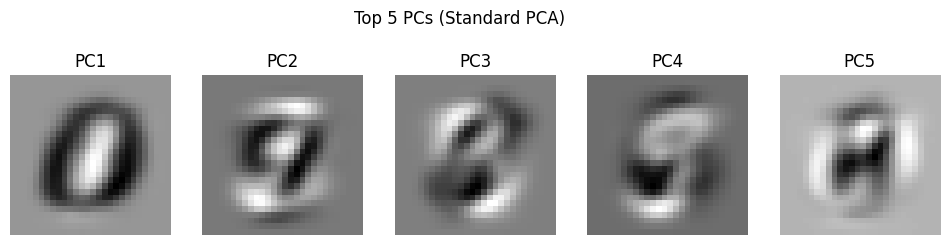

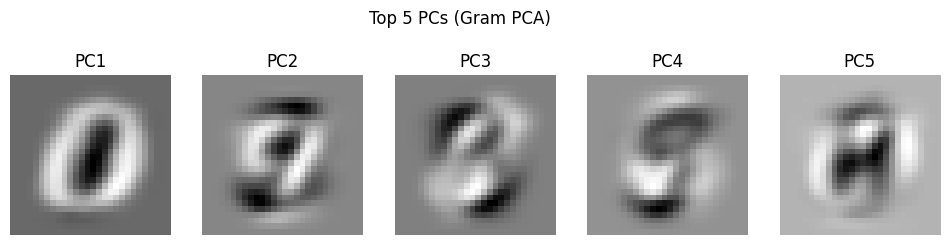

In [7]:
def plot_pcs(pcs, title):
    plt.figure(figsize=(12, 3))
    for i in range(pcs.shape[1]):
        plt.subplot(1, pcs.shape[1], i+1)
        plt.imshow(pcs[:, i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'PC{i+1}')
    plt.suptitle(title)
    plt.show()

plot_pcs(eigvecs_std, "Top 5 PCs (Standard PCA)")
plot_pcs(eigvecs_gram, "Top 5 PCs (Gram PCA)")

(b)

In the MNIST dataset, the number of samples (1000) is much larger than the feature dimension of each image (784). Since the Gram matrix method is only more efficient when the number of samples is smaller than the number of features, using the Gram matrix approach (based on $X X^\top$) does not provide any computational advantage and may actually slow down the process due to the larger matrix size.

(c)

Image reconstruct and MSE

In [8]:
def reconstruct_image(img, eigvecs, mean_X, n_list=[1, 2, 5, 10, 20]):
    img_centered = img - mean_X
    results = []
    for n in n_list:
        pcs = eigvecs[:, :n] # choose top-n PCs
        coeffs = pcs.T @ img_centered # projection coefficients
        recon = pcs @ coeffs + mean_X # reconstruction
        mse = np.linalg.norm(img - recon)**2
        results.append((recon, mse))
    return results

img_idx = 0
img_original = x_train_flat[img_idx]

recon_std = reconstruct_image(img_original, eigvecs_std, mean_X_std)
recon_gram = reconstruct_image(img_original, eigvecs_gram, mean_X_gram)

Visualization:

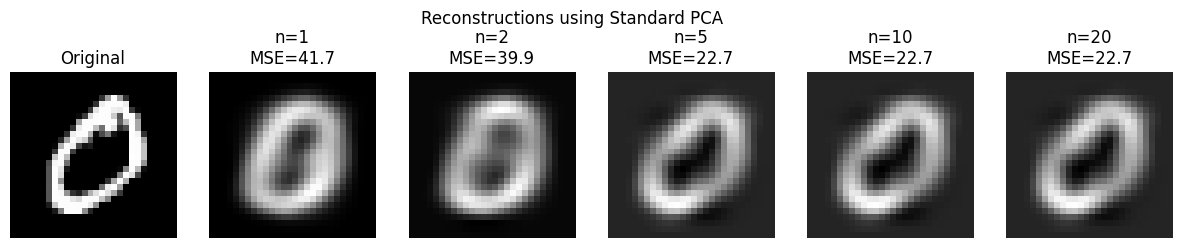

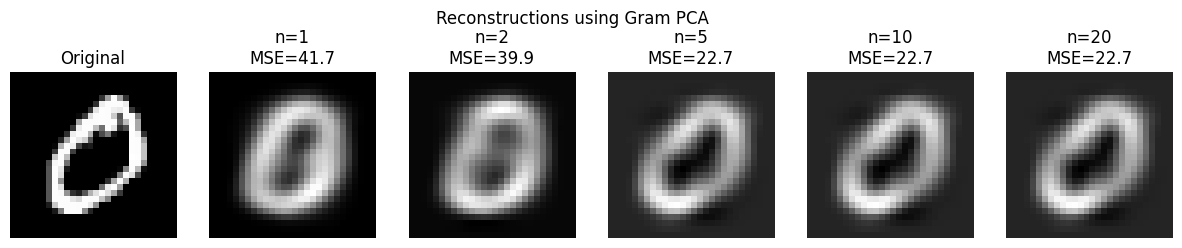

In [9]:
def plot_reconstructions(original, recon_list, method_name, n_list=[1,2,5,10,20]):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, len(n_list)+1, 1)
    plt.imshow(original.reshape(28,28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    for i, (recon, mse) in enumerate(recon_list):
        plt.subplot(1, len(n_list)+1, i+2)
        plt.imshow(recon.reshape(28,28), cmap='gray')
        plt.title(f"n={n_list[i]}\nMSE={mse:.1f}")
        plt.axis('off')
    plt.suptitle(f"Reconstructions using {method_name}")
    plt.show()

plot_reconstructions(img_original, recon_std, "Standard PCA")
plot_reconstructions(img_original, recon_gram, "Gram PCA")